In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Dataset, Reader, NMF, SVD, KNNBasic, accuracy
from surprise.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt

In [55]:
ratings = pd.read_csv('/Users/cathleen/Documents/goodreads_data/ratings.csv')
books = pd.read_csv('/Users/cathleen/Documents/goodreads_data/books.csv')
books.head()


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


Normal rating
median: 4.000000, 25perc: 3.000000, 75perc: 5.000000


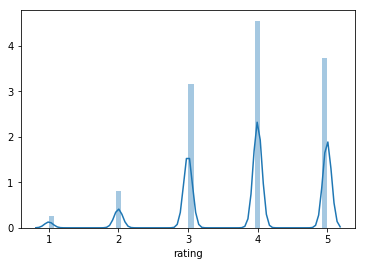

User num rating
min number of rating 2.000000
median: 8.000000, 25perc: 3.000000, 75perc: 22.000000


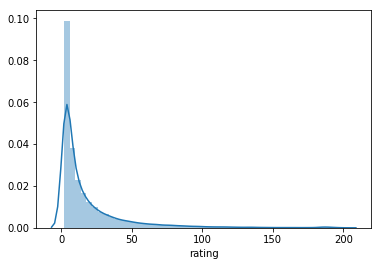

Content num rating
min number of rating 8.000000
median: 100.000000, 25perc: 99.000000, 75perc: 100.000000


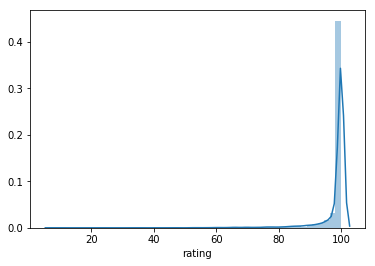

Avg rating
ratings from 1.960000 to 4.820225
median: 3.870000, 25perc: 3.670000, 75perc: 4.060000


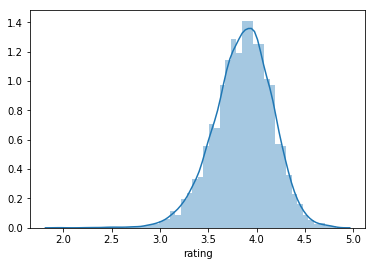

Avg rating by Count


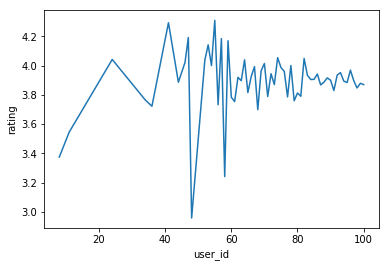

In [51]:
# visualize

# distribution of ratings 
def visualizeDistribution(data):
    rating_median = np.percentile(data.rating, q = 50)
    rating_25 = np.percentile(data.rating, q= 25)
    rating_75 = np.percentile(data.rating, q= 75)
    print('median: %f, 25perc: %f, 75perc: %f' % (rating_median, rating_25, rating_75))
    sns.distplot(data.rating)
    plt.show()

#  the distribution of number of ratings given
def visualizeRatingsbyGroup(data, group_id):
    data_grouped = data.groupby([group_id]).count()['rating'].reset_index()
    min_num = min(data_grouped.rating)
    print('min number of rating %f' % (min_num))
    visualizeDistribution(data_grouped)

#  the distribution of avg ratings for each group 
def visualizeAvgRatingsbyGroup(data, group_id):
    data_grouped = data.groupby([group_id]).mean()['rating'].reset_index()
    min_num = min(data_grouped.rating)
    max_num = max(data_grouped.rating)
    print('ratings from %f to %f' % (min_num, max_num))
    visualizeDistribution(data_grouped)

def visualizeAvgRatingsbyCount(data):
    user_number = data.groupby(['book_id']).count()['user_id'].reset_index()
    avg_rating = data.groupby(['book_id']).mean()['rating'].reset_index()
    user_number = user_number.set_index('book_id')
    avg_rating = avg_rating.set_index('book_id')
    joined = avg_rating.join(user_number, on = 'book_id').reset_index()
    rating_by_count = joined.groupby(['user_id']).median()['rating'].reset_index()
    sns.lineplot(x = 'user_id', y = 'rating', data =rating_by_count) 


def visualizeAllRatings(data):
    print('Normal rating')
    # Most  ratings are 4 or above. Left skew distribution
    visualizeDistribution(data)
    # About 25% of users only had one book rating, we probably want to exclude 
    print('User num rating')
    visualizeRatingsbyGroup(data, 'user_id')
    # Every book has at least 8 ratings 
    print('Content num rating')
    visualizeRatingsbyGroup(data, 'book_id')
    # Avg rating
    print('Avg rating')
    visualizeAvgRatingsbyGroup(data, 'book_id')
    # Avg rating by count
    print('Avg rating by Count')
    visualizeAvgRatingsbyCount(data)


visualizeAllRatings(ratings)



Normal rating
median: 4.000000, 25perc: 3.000000, 75perc: 5.000000


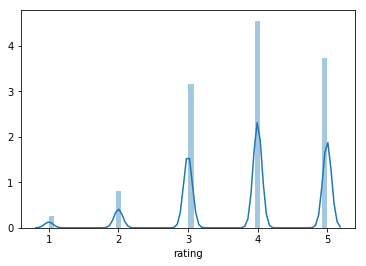

User num rating
min number of rating 3.000000
median: 11.000000, 25perc: 5.000000, 75perc: 26.000000


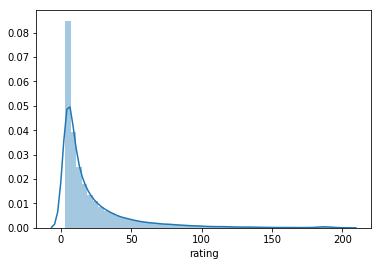

Content num rating
min number of rating 6.000000
median: 100.000000, 25perc: 98.000000, 75perc: 100.000000


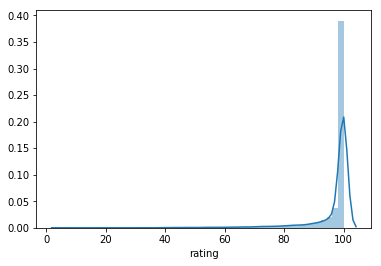

Avg rating
ratings from 1.949495 to 4.802817
median: 3.870000, 25perc: 3.670000, 75perc: 4.060000


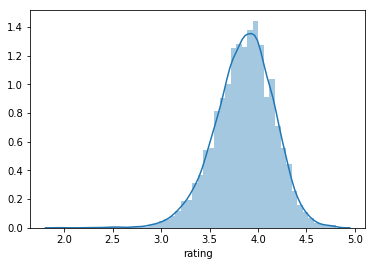

Avg rating by Count


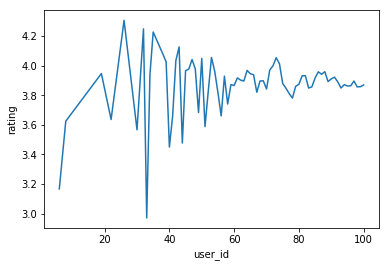

In [53]:
# filter out users with less than 3 ratings from data 

def filterData(data):
    data_grouped = data.groupby(['user_id']).count()['rating'].reset_index()
    users = data_grouped[data_grouped.rating>2].user_id
    new_data = data[data.user_id.isin(users)]
    return new_data
    
new_data= filterData(ratings)
visualizeAllRatings(new_data)

In [54]:
# load data into surprise reader format

reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(new_data[['user_id', 'book_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size = 0.2)

# algos = [SVD(), KNNBasic()]
# for algo in algos:
#     algo.fit(train_data)
#     predictions = algo.test(test_data)
#     accuracy.rmse(predictions)

In [ ]:


def genMissingPredictions(data, model): 
    testset = data.build_anti_testset()
    predictions = model.test(testset)
    return predictions

def getTopNPredictions(predictions, n = 10):
    top_n = {}
    for user_id, book_id, true_r, est, _ in predictions:
        top_n[user_id] = top_n.get(user_id, []).append((book_id, est))
    
    for user_id, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse= True)
        top_n[user_id] = user_ratings[:n]
    
    return top_n


algo = SVD()
algo.fit(train_data)
predictions = genMissingPredictions(train_data, algo)

    

In [ ]:
def printData(user_id, train_data, predictions, books):
    # for a user, print out examples of books they selected and predictions
    user_data = train_data[train_data.user_id == user_id]
    user_prediction = predictions[user_id]
    read_books = []
    prediction_books = []
    for row in user_data.iterrows():
        read_books.append(findBookName(row.book_id, books))
    for book in user_prediction:
        prediction_books.append(findBookName(book, books))
    print(read_books)
    print(prediction_books)
    return read_books, prediction_books
    
    
    
def findBookName(book_id, books):
    # rturn the name of the book for each id
    book_row = books[books.book_id == book_id]
    return str(book_row.original_title) + '_' + str(book_row.authors)



prediction_user_id = []